In [117]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import warnings
warnings.filterwarnings('ignore')

The scikit-learn version is 0.21.1.


In [118]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [119]:
X, y = mnist['data'], mnist['target']

In [120]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [121]:
import numpy as np
y = y.astype(np.int)

In [122]:
np.sqrt(X.shape[1])

28.0

In [123]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

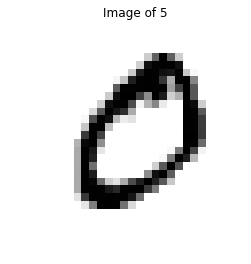

In [124]:
def show_img(x):
    some_digit_image = x.reshape(28,28)
    plt.imshow(some_digit_image, cmap=cm.binary, interpolation='nearest')
    plt.title("Image of " + str(y[0]))
    plt.axis('off')
    
show_img(X[1])

### Train & Test Split

In [125]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [126]:
#Shuffle
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

## 3.2 이진 분류기 훈련

In [127]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [128]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [129]:
sgd_clf.predict([X[0]])[0]

True

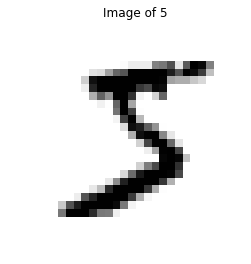

In [130]:
show_img(X[0])

## 3.3 성능 측정

In [131]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [132]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [133]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_test_folds))

0.96475
0.9491
0.9611


In [134]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96475, 0.9491 , 0.9611 ])

In [135]:
from sklearn.base import BaseEstimator

class DummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool) 

In [136]:
dummy = DummyClassifier()
cross_val_score(dummy, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.908  , 0.91075, 0.9102 ])

## 3.3.2 오차 행렬

In [137]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [138]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53987,   592],
       [ 1909,  3512]])

### 3.3.3 정밀도와 재현율

In [139]:
from sklearn.metrics import precision_score, recall_score
print("Predcision %.3f" % precision_score(y_train_5, y_train_pred))
print("Recall %.3f" % recall_score(y_train_5, y_train_pred))

Predcision 0.856
Recall 0.648


In [140]:
#f1 score
p_score = precision_score(y_train_5, y_train_pred)
r_score = recall_score(y_train_5, y_train_pred)
2 * (p_score * r_score) / (p_score + r_score)

0.7374278215223097

In [141]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7374278215223097

## 3.3.4 정밀도/재현율 트레이드 오프

In [142]:
y_prob = sgd_clf.decision_function(X_test)

In [143]:
y_pred = (y_prob > 0)

In [144]:
print("Predcision %.3f" % precision_score(y_test_5, y_pred))
print("Recall %.3f" % recall_score(y_test_5, y_pred))

Predcision 0.946
Recall 0.531


In [145]:
y_pred = (y_prob > 200000)

In [146]:
print("Predcision %.3f" % precision_score(y_test_5, y_pred))
print("Recall %.3f" % recall_score(y_test_5, y_pred))

Predcision 0.971
Recall 0.074


In [147]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test_5, y_prob)

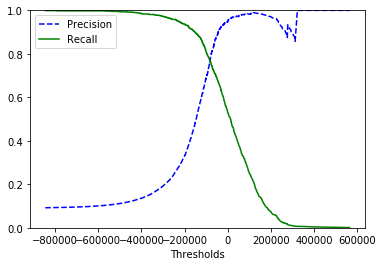

In [148]:
def plot_tradeoff(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend()
    plt.ylim([0,1])

plot_tradeoff(precisions, recalls, thresholds)

### 3.3.5 ROC Curve

In [149]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_5, y_prob)

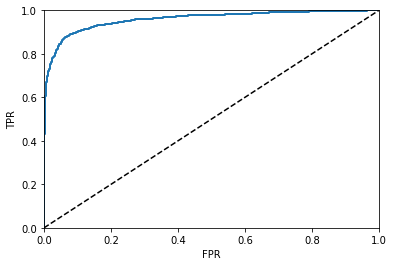

In [150]:
def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0,1])

plot_roc(fpr,tpr)

In [151]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_5, y_prob)

0.9590604081367388

In [152]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
y_probs = cross_val_predict(rf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_rf = y_probs[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

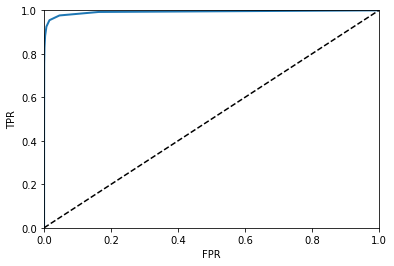

In [153]:
plot_roc(fpr_rf,tpr_rf)

In [159]:
roc_auc_score(y_train_5, y_score_rf) ### 확인필요

0.4989798925692919